In [1]:
import gempyor

In [2]:
config_filepath = "../tests/npi/config_npi.yml"
gempyor_simulator = gempyor.InferenceSimulator(
    config_path=config_filepath,
    run_id="test_run_id",
    prefix="test_prefix/",
    first_sim_index=1,
    scenario="inference",  # NPIs scenario to use
    deathrate="med",  # Outcome scenario to use
    stoch_traj_flag=False,
    spatial_path_prefix="../tests/npi/",  # prefix where to find the folder indicated in spatial_setup$
)

  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> Setup USA_inference; index: 1; run_id: test_run_id,
  gempyor >> prefix: test_prefix/;


In [3]:
npi_seir = (
    gempyor_simulator.get_seir_npi()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_snpi_df>) or (bypass_FN=<some_snpi_filename>)
npi_outcome = (
    gempyor_simulator.get_outcome_npi()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_hnpi_df>) or (bypass_FN=<some_hnpi_filename>)
params_draw_df = (
    gempyor_simulator.get_seir_parametersDF()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
params_draw_arr = (
    gempyor_simulator.get_seir_parameters()
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
param_reduc = gempyor_simulator.get_seir_parameter_reduced(
    npi_seir=npi_seir
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)
param_reduc_from = gempyor_simulator.get_seir_parameter_reduced(
    npi_seir=npi_seir, p_draw=params_draw_arr
)  # could also accept (load_ID=True, sim_id2load=XXX) or (bypass_DF=<some_spar_df>) or (bypass_FN=<some_spar_filename>)

INFO:root:[SEIR.NPI] completed in 52.72 s
INFO:root:[Outcomes.NPI] completed in 1.45 s


<AxesSubplot:>

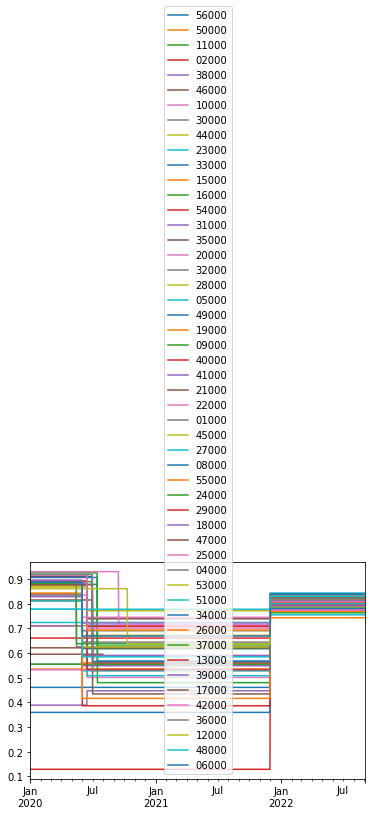

In [9]:
mpi_outcome.getReduction("inciditoc_all").T.plot()

In [3]:
gempyor_simulator.plot_transition_graph(output_file="full_graph")
gempyor_simulator.plot_transition_graph(
    output_file="readable_graph",
    source_filters=[["age0to17"], ["OMICRON", "WILD"]],
    destination_filters=[["OMICRON", "WILD"]],
)

In [15]:
import pathlib
from gempyor import seir, setup, file_paths
from gempyor import outcomes
from gempyor.utils import config, Timer
import numpy as np
from concurrent.futures import ProcessPoolExecutor

### Logger configuration
import logging
import os
import functools
import multiprocessing as mp

load_ID = False
sim_id2load = None
sim_id2write = 0


gempyor_simulator.outcomes_parameters = outcomes.read_parameters_from_config(gempyor_simulator.s)

npi_outcomes = None

if not gempyor_simulator.already_built:
    (
        gempyor_simulator.unique_strings,
        gempyor_simulator.transition_array,
        gempyor_simulator.proportion_array,
        gempyor_simulator.proportion_info,
    ) = gempyor_simulator.s.compartments.get_transition_array()
    gempyor_simulator.already_built = True
npi_seir = seir.build_npi_SEIR(s=gempyor_simulator.s, load_ID=load_ID, sim_id2load=sim_id2load, config=config)
if gempyor_simulator.s.npi_config_outcomes:
    npi_outcomes = outcomes.build_npi_Outcomes(
        s=gempyor_simulator.s,
        load_ID=load_ID,
        sim_id2load=sim_id2load,
        config=config,
    )

### Run every time:
with Timer("onerun_SEIR.seeding"):
    if load_ID:
        initial_conditions = gempyor_simulator.s.seedingAndIC.load_ic(sim_id2load, setup=gempyor_simulator.s)
        seeding_data, seeding_amounts = gempyor_simulator.s.seedingAndIC.load_seeding(
            sim_id2load, setup=gempyor_simulator.s
        )
    else:
        initial_conditions = gempyor_simulator.s.seedingAndIC.draw_ic(sim_id2write, setup=gempyor_simulator.s)
        seeding_data, seeding_amounts = gempyor_simulator.s.seedingAndIC.draw_seeding(
            sim_id2write, setup=gempyor_simulator.s
        )

with Timer("SEIR.parameters"):
    # Draw or load parameters
    if load_ID:
        p_draw = gempyor_simulator.s.parameters.parameters_load(
            param_df=gempyor_simulator.s.read_simID(ftype="spar", sim_id=sim_id2load),
            n_days=gempyor_simulator.s.n_days,
            nnodes=gempyor_simulator.s.nnodes,
        )
    else:
        p_draw = gempyor_simulator.s.parameters.parameters_quick_draw(
            n_days=gempyor_simulator.s.n_days, nnodes=gempyor_simulator.s.nnodes
        )
    # reduce them
    parameters = gempyor_simulator.s.parameters.parameters_reduce(p_draw, npi_seir)

    # Parse them
    parsed_parameters = gempyor_simulator.s.compartments.parse_parameters(
        parameters,
        gempyor_simulator.s.parameters.pnames,
        gempyor_simulator.unique_strings,
    )

loaded_values = None
if load_ID:
    loaded_values = gempyor_simulator.s.read_simID(ftype="hpar", sim_id=sim_id2load)

# Compute outcomes
with Timer("onerun_delayframe_outcomes.compute"):
    outcomes_df, hpar_df = outcomes.compute_all_multioutcomes(
        s=gempyor_simulator.s,
        sim_id2write=sim_id2write,
        parameters=gempyor_simulator.outcomes_parameters,
        loaded_values=loaded_values,
        npi=npi_outcomes,
    )

with Timer("onerun_delayframe_outcomes.postprocess"):
    outcomes.postprocess_and_write(
        sim_id=sim_id2write,
        s=gempyor_simulator.s,
        outcomes=outcomes_df,
        hpar=hpar_df,
        npi=npi_outcomes,
    )

INFO:root:[Outcome.structure] completed in 0.01 s
INFO:root:[SEIR.NPI] completed in 38.21 s
INFO:root:[Outcomes.NPI] completed in 0.90 s
INFO:root:[onerun_SEIR.seeding] completed in 3.33 s
INFO:root:[SEIR.parameters] completed in 0.08 s
/Users/chadi/opt/miniconda3/envs/covidSProd6/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/chadi/opt/miniconda3/envs/covidSProd6/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
INFO:root:[onerun_delayframe_outcomes.compute] complete

In [4]:
gempyor_simulator.one_simulation(sim_id2write=0)
gempyor_simulator.one_simulation(sim_id2write=0, load_ID=TRUE, sim_id2load=0)

INFO:root:[Outcome.structure] completed in 0.02 s
INFO:root:[SEIR.compartments] completed in 29.69 s
INFO:root:[SEIR.NPI] completed in 50.01 s
INFO:root:[Outcomes.NPI] completed in 1.09 s
INFO:root:[onerun_SEIR.seeding] completed in 5.24 s
INFO:root:[SEIR.parameters] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.compute] completed in 0.22 s
INFO:root:[>>> GEMPYOR onesim (from config)] completed in 86.38 s


ValueError: with method rk4.jit, only deterministicintegration is possible (got stoch_straj_flag=1